In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import duckdb
import fastparquet

In [2]:
if os.path.exists('/Users/dan/Desktop/Fin7034_QuantTrading/Quant_Assignments/HomeFun3'):
    data_folder = '/Users/dan/Desktop/Fin7034_QuantTrading/Quant_Assignments/HomeFun3'
    os.chdir(data_folder)   
else:
    print('Please point to the right data path!')

In [13]:
import duckdb
import pandas as pd

# Connect to DuckDB
con = duckdb.connect()

# SQL query to compute the daily Amihud illiquidity measure,
# the rolling one-year (252-day) average,
# and the trading day within each month (restricting to the first 10 trading days).
query = """
WITH base AS (
    -- 1. Load the base CRSP data from the parquet file.
    SELECT 
        permno,
        CAST(dlycaldt AS DATE) AS date,
        dlyprc AS price,
        dlyret AS ret,
        dlycap AS market_cap,
        dlybid AS bid,
        dlyask AS ask,
        dlyvol AS volume,
        dlyprcvol AS price_volume,
        dlyhigh AS high,
        dlylow AS low
    FROM read_parquet('data/crsp_202401.dsf_v2.parquet')
    WHERE dlycaldt BETWEEN '1995-07-01' AND '2023-12-31'
),
illiq AS (
    -- 2. Compute the daily Amihud illiquidity measure.
    SELECT 
        permno,
        date,
        ret,
        market_cap,
        price_volume,
        ABS(ret) / NULLIF(price_volume, 0) * 1e6 AS illiq_daily
    FROM base
),
rolling AS (
    -- 3. Compute the rolling one-year (252-day) average illiquidity using a window function.
    SELECT 
        permno,
        date,
        illiq_daily,
        price_volume,
        ret,
        market_cap,
        AVG(illiq_daily) OVER (
            PARTITION BY permno 
            ORDER BY date 
            ROWS BETWEEN 251 PRECEDING AND CURRENT ROW
        ) AS illiq_rolling
    FROM illiq
),
trading AS (
    -- 4. Determine the trading day within each month.
    SELECT 
        *,
        DATE_TRUNC('month', date) AS month_start,
        ROW_NUMBER() OVER (
            PARTITION BY permno, DATE_TRUNC('month', date)
            ORDER BY date
        ) AS trading_day
    FROM rolling
)
SELECT *
FROM trading
ORDER BY permno, date;
"""

# Execute query and fetch results as a DataFrame
df_illiq = con.execute(query).fetch_df()

# Close the connection
con.close()
print(df_illiq.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   permno       date  illiq_daily  price_volume       ret  market_cap  \
0   10001 1995-07-03     0.000000        1650.0  0.000000    18595.50   
1   10001 1995-07-05     5.196077       11663.8 -0.060606    17468.50   
2   10001 1995-07-06     2.005159       32175.0  0.064516    18595.50   
3   10001 1995-07-07          NaN           0.0 -0.030303    18032.00   
4   10001 1995-07-10     1.423159       20585.9  0.029297    18560.28   

   illiq_rolling month_start  trading_day  
0       0.000000  1995-07-01            1  
1       2.598038  1995-07-01            2  
2       2.400412  1995-07-01            3  
3       2.400412  1995-07-01            4  
4       2.156099  1995-07-01            5  


In [14]:
# in sample period from 1995-07-01 to 2013-12-31
df_illiq = df_illiq[df_illiq['date'] <= '2013-12-31']

df_illiq['month'] = df_illiq['date'].dt.to_period('M')
df_illiq = df_illiq.dropna(subset=['illiq_daily'])
df_illiq['illiq_bin'] = df_illiq.groupby('month')['illiq_daily'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')+1)

# Filter the most liquid stocks
df_most_liquid = df_illiq[df_illiq['illiq_bin'] == 10]

In [15]:
# First convert df_most_liquid to a temporary table in DuckDB
con = duckdb.connect()

# Convert the DataFrame to a format DuckDB can handle
df_most_liquid['month'] = df_most_liquid['month'].astype(str)  # Convert period to string
con.register('df_most_liquid_temp', df_most_liquid)

vw_query_liquid = """
WITH 
month_end AS (
    -- Get the last trading day's market cap for each month
    SELECT 
        permno,
        LAST_DAY(LAST(date)) AS month_end_date,
        LAST(market_cap) AS lagged_mktcap
    FROM df_most_liquid_temp
    WHERE market_cap IS NOT NULL
    GROUP BY permno, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
),
merged_data AS (
    -- Merge the lagged market cap with the next month's returns
    SELECT 
        liquid.*,
        m.lagged_mktcap
    FROM df_most_liquid_temp liquid
    LEFT JOIN month_end m
    ON liquid.permno = m.permno
    AND m.month_end_date = LAST_DAY(liquid.date - INTERVAL 1 MONTH)
)
-- Calculate value-weighted returns for each day
SELECT
    date,
    SUM(ret * lagged_mktcap) / NULLIF(SUM(lagged_mktcap), 0) AS vw_ret
FROM merged_data
WHERE lagged_mktcap IS NOT NULL
AND ret IS NOT NULL
GROUP BY date
ORDER BY date
"""

vw_returns_liquid = con.execute(vw_query_liquid).fetch_df()
vw_returns_liquid['date'] = pd.to_datetime(vw_returns_liquid['date'])
vw_returns_liquid.rename(columns={'vwret_liquid': 'vw_ret_liquid'}, inplace=True)

con.close()

vw_returns_liquid

,date,vw_ret
0,2001-05-01,0.007816
1,2001-05-02,0.008597
2,2001-05-03,-0.007107
3,2001-05-04,0.009950
4,2001-05-07,-0.003774
...,...,...
3182,2013-12-24,-0.001529
3183,2013-12-26,0.010076
3184,2013-12-27,0.003759
3185,2013-12-30,-0.006447


In [16]:
# Identify Trading Days Relative to Month End
# label trading days relative to month end
def label_trading_days(df):
    df = df.sort_values('date')
    df['month'] = df['date'].dt.to_period('M')
    
    # Initialize trading day labels
    df['trading_day'] = np.nan 
    
    for month in df['month'].unique():
        month_data = df[df['month'] == month]
        n_days = len(month_data)
        
        for i, idx in enumerate(month_data.index):
            days_to_end = n_days - i - 1
            if days_to_end <= 8:
                df.loc[idx, 'trading_day'] = -days_to_end
             
        next_month_data = df[df['month'] == month + 1]
        for i, idx in enumerate(next_month_data.index[:8]):
            df.loc[idx, 'trading_day'] = i + 1
            
    return df

daily_vw_returns = label_trading_days(vw_returns_liquid)


Period Statistics:
                mean       std  count  abnormal_ret    t_stat       p_value
period                                                                     
T+4_to_T+8 -0.001787  0.013056    753     -0.001435 -3.015206  2.654462e-03
T-3_to_T-1  0.001026  0.011820    456      0.001378  2.488966  1.316794e-02
T-8_to_T-4 -0.001213  0.014112    760     -0.000861 -1.681375  9.310158e-02
T_0         0.008197  0.012494    152      0.008549  8.436355  2.464695e-14
T_1 to_T+3 -0.000992  0.014560    453     -0.000640 -0.936194  3.496732e-01
other      -0.000194  0.012915    613      0.000158  0.302572  7.623185e-01


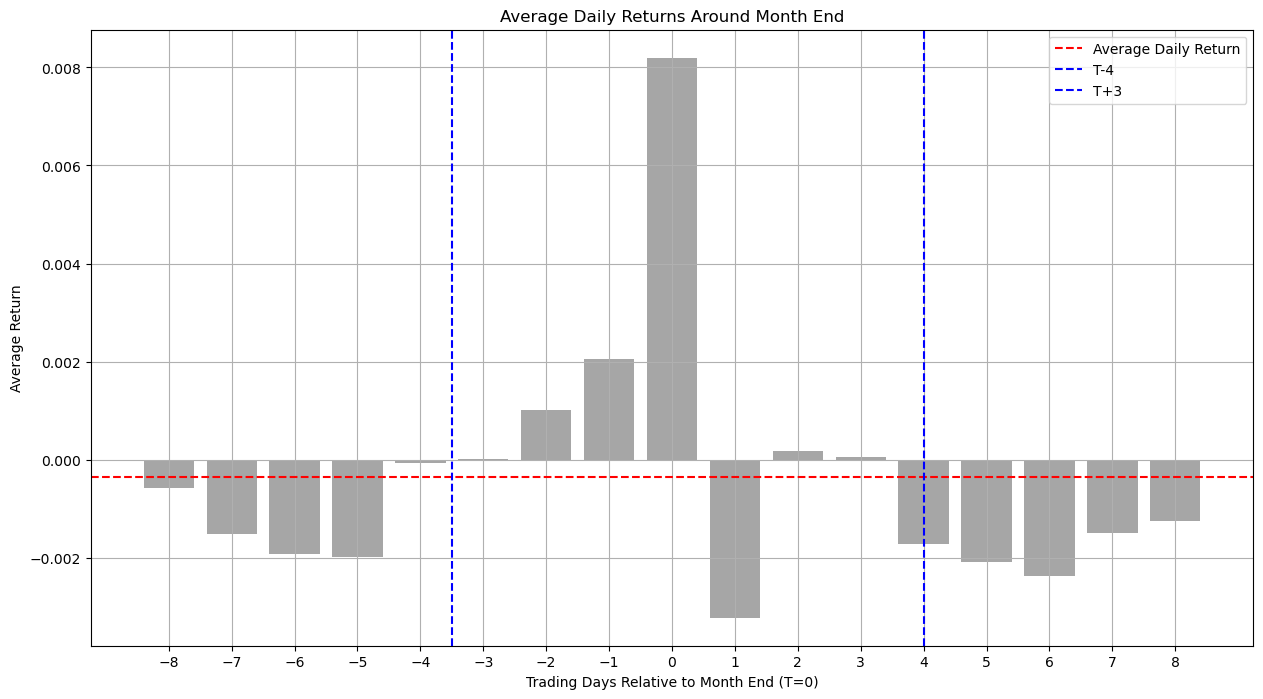

In [17]:
# get Period Returns
# Define the periods according to the paper
daily_vw_returns['period'] = 'other'
# daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-10,-9), 'period'] = 'T_10_to_T_9'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-8, -4), 'period'] = 'T-8_to_T-4'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-3, -1), 'period'] = 'T-3_to_T-1'
daily_vw_returns.loc[daily_vw_returns['trading_day'] == 0, 'period'] = 'T_0'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(1, 3), 'period'] = 'T_1 to_T+3'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(4, 8), 'period'] = 'T+4_to_T+8'
# daily_vw_returns.loc[daily_vw_returns['trading_day'].between(9, 10), 'period'] = 'T+9_to_T+10'

# get average returns by period
period_stats = daily_vw_returns.groupby('period')['vw_ret'].agg(['mean', 'std', 'count'])
avg_daily_ret = daily_vw_returns['vw_ret'].mean()

# compute abnormal returns
period_stats['abnormal_ret'] = period_stats['mean'] - avg_daily_ret
period_stats['t_stat'] = (period_stats['abnormal_ret'] * np.sqrt(period_stats['count']) / 
                         period_stats['std'])
period_stats['p_value'] = 2 * (1 - stats.t.cdf(abs(period_stats['t_stat']), 
                                              period_stats['count'] - 1))

print("\nPeriod Statistics:")
print(period_stats)

# plot the graph
plt.figure(figsize=(15, 8))
daily_means = daily_vw_returns.groupby('trading_day')['vw_ret'].mean()

# plt.plot(daily_means.index, daily_means.values, marker='o')
plt.bar(daily_means.index, daily_means.values, color='grey', alpha=0.7)
plt.axhline(y=avg_daily_ret, color='r', linestyle='--', label='Average Daily Return')
plt.axvline(x=-3.5, color='b', linestyle='--', label='T-4')
plt.axvline(x=4, color='b', linestyle='--', label='T+3')
plt.title('Average Daily Returns Around Month End')
plt.xlabel('Trading Days Relative to Month End (T=0)')
plt.ylabel('Average Return')
x_ticks = range(int(min(daily_means.index)), int(max(daily_means.index))+1)
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.show()

### Loading the Macro News data

In [18]:
# loading the CPI data
cpi = pd.read_excel('data/CPI.xlsx')
cpi = cpi[cpi['Event']== 'CPI MoM'].sort_values('Date Time')
# keep only the date
cpi['Date'] = pd.to_datetime(cpi['Date Time']).dt.date
# Retain only the relevant columns and drop duplicates
cpi = cpi[['Date', 'Actual', 'Survey','Prior']].drop_duplicates()
# rename the columns
cpi = cpi.rename(columns={
    'Survey': 'Survey_Value',
    'Actual': 'Actual_Value'
})
# add the announcement type
cpi['Announcement_Type'] = 'CPI'

# loading the FOMC data
FOMC = pd.read_excel('data/FOCM.xlsx')
FOMC = FOMC[FOMC['Event']== 'FOMC Rate Decision (Upper Bound)'].sort_values('Date Time')
FOMC['Date'] = pd.to_datetime(FOMC['Date Time']).dt.date
FOMC = FOMC[['Date', 'Actual', 'Surv(M)', 'Surprise', 'Prior']].drop_duplicates()
FOMC = FOMC.rename(columns={
    'Surv(M)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
FOMC['Announcement_Type'] = 'FOMC'

# loading the unemployment data
unemployment = pd.read_excel('data/Unemployment.xlsx')
unemployment = unemployment[unemployment['Event']== 'Unemployment Rate'].sort_values('Date Time')
unemployment['Date'] = pd.to_datetime(unemployment['Date Time']).dt.date
unemployment = unemployment[['Date', 'Actual', 'Surv(M)', 'Surprise', 'Prior']].drop_duplicates()
unemployment = unemployment.rename(columns={
    'Surv(M)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
unemployment['Announcement_Type'] = 'Unemployment'

In [19]:
# First strip whitespace and then replace '--' with NaN
FOMC['Survey_Value'] = pd.to_numeric(FOMC['Survey_Value'], errors='coerce')

# forward fill the missing survey values for an unexpected FOMC
FOMC['Survey_Value'] = FOMC['Survey_Value'].fillna(FOMC['Prior'])

# get the difference
# how much the rate change from the prior meeting
FOMC['Acutal_prior_diff'] = FOMC['Actual_Value'] - FOMC['Prior']
# how much the expected rate change from the prior meeting, showing the market sentiment?
FOMC['Survey_prior_diff'] = FOMC['Survey_Value'] - FOMC['Prior']

# difference between the expected rate and actual rate, showing potential market sentiment
FOMC['diff'] = FOMC['Survey_Value'] - FOMC['Actual_Value']

FOMC['rate_change'] = FOMC['Actual_Value'] - FOMC['Prior']

(FOMC['rate_change'] <0).sum()

np.int64(34)

In [20]:
# Combine all macro announcements
macro_announcements = pd.concat([cpi, FOMC, unemployment])
macro_announcements

# Create dummy variables for each announcement type
macro_announcements = pd.get_dummies(macro_announcements, 
                                    columns=['Announcement_Type'],
                                    prefix='',
                                    prefix_sep='')


# Ensure 'date' in daily_vw_returns is datetime
daily_vw_returns['date'] = pd.to_datetime(daily_vw_returns['date'])

# Ensure 'Date' in macro_announcements is datetime
macro_announcements['Date'] = pd.to_datetime(macro_announcements['Date'])

# Merge with returns data
merged_data = daily_vw_returns.merge(
    macro_announcements,
    left_on='date',
    right_on='Date',
    how='left'
)


# Fill missing announcement dummies with 0
announcement_types = ['CPI', 'FOMC', 'Unemployment']
for atype in announcement_types:
    merged_data[atype] = merged_data[atype].fillna(0)

# Create turn-of-the-month dummy (using your trading_day labels)
merged_data['turn_of_month'] = ((merged_data['trading_day'] >=-3) & 
                               (merged_data['trading_day'] <=3)).astype(int)

# create the dummy variables for each period
period_dummies = pd.get_dummies(merged_data['period'], dtype=int)

# Merge the dummy variables with the original dataframe
merged_data = pd.concat([merged_data, period_dummies], axis=1)

# Create FOMC dummy (1 for FOMC announcement days, 0 otherwise)
merged_data['FOMC'] = merged_data['Date'].notna().astype(int)

# rate cut and hike period dummies
merged_data['Rate_Cut'] = ((merged_data['Actual_Value'] < merged_data['Prior']) & 
                          (merged_data['FOMC'] == 1)).astype(int)
merged_data['Rate_Hike'] = ((merged_data['Actual_Value'] > merged_data['Prior']) & 
                           (merged_data['FOMC'] == 1)).astype(int)

# # loose good and bad news indicators
merged_data['Good'] = ((merged_data['rate_change'] <0)).astype(int)
merged_data['Bad'] = ((merged_data['rate_change'] >0)).astype(int)

# Create Good and Bad news indicators, given the difference between the expected rate and actual rate
# Good news: the expected rate is higher than the actual rate, showing the rate cut is higher than the market expected
# Bad news: the expected rate is lower than the actual rate, showing the rate hike is higher than the market expected
# merged_data['Good'] = ((merged_data['diff'] > 0)).astype(int)
# merged_data['Bad'] = ((merged_data['diff'] < 0)).astype(int)



# Create dummies for each period based on trading_day
merged_data['selling_pressure'] = (merged_data['trading_day'].between(-8, -4)).astype(int)
merged_data['positive_reversal'] = (merged_data['trading_day'].between(-3, -1)).astype(int)
merged_data['month_end'] = (merged_data['trading_day'] == 0).astype(int)
merged_data['buying_pressure'] = (merged_data['trading_day'].between(1, 3)).astype(int)
merged_data['negative_reversal'] = (merged_data['trading_day'].between(4, 8)).astype(int)


# Run regression
model = smf.ols(
    formula='vw_ret ~ turn_of_month*Good*Rate_Cut',
    data=merged_data
).fit()

# Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 vw_ret   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     5.683
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           3.17e-05
Time:                        20:37:14   Log-Likelihood:                 9231.2
No. Observations:                3193   AIC:                        -1.845e+04
Df Residuals:                    3187   BIC:                        -1.841e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [21]:
def plot_macro_by_type(ret):
    """
    Plot the monthly pattern of returns, comparing days with and without each macro announcement type.
    
    Parameters:
        ret (DataFrame): DataFrame with daily returns (vw_ret), a 'trading_day' column, 
                           and dummy columns for each macro announcement type (CPI, FOMC, Unemployment).
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # List of macro announcement types (these columns should be 1 if the event occurred, 0 otherwise)
    macro_types = ['CPI', 'FOMC', 'Unemployment']

    # Create a subplot grid: 1 row x number of macro types columns
    fig, axes = plt.subplots(1, len(macro_types), figsize=(18, 6))

    # If only one macro type is present, force axes to be iterable
    if len(macro_types) == 1:
        axes = [axes]

    # Loop over the macro types, and for each, filter days with and without the announcement.
    for idx, mtype in enumerate(macro_types):
        ax = axes[idx]
        
        # Filter data for days with and without the current macro announcement type
        with_macro = ret[ret[mtype] == 1]
        without_macro = ret[ret[mtype] == 0]

        # Calculate average returns by trading day for both groups
        with_macro_means = with_macro.groupby('trading_day')['vw_ret'].mean()
        without_macro_means = without_macro.groupby('trading_day')['vw_ret'].mean()

        # Plot the lines comparing the two groups
        ax.plot(without_macro_means.index, without_macro_means.values, 
                marker='o', label=f'Days without {mtype} News', color='blue', alpha=0.7)
        ax.plot(with_macro_means.index, with_macro_means.values, 
                marker='s', label=f'Days with {mtype} News', color='red', alpha=0.7)

        # Add reference lines
        ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
        ax.axvline(x=-4, color='green', linestyle='--', label='T-4', alpha=0.5)
        ax.axvline(x=3, color='green', linestyle='--', label='T+3', alpha=0.5)

        # Shade selected periods:
        # Selling Pressure: T-8 to T-4
        ax.axvspan(-8, -4, color='red', alpha=0.1, label='Selling Pressure')
        # Turn-of-Month (ToM) Effect: T-3 to T+3
        ax.axvspan(-3, 3, color='green', alpha=0.1, label='ToM Effect')

        # Customize each subplot
        ax.set_title(f'Turn-of-Month Returns: {mtype} Announcement vs. None')
        ax.set_xlabel('Trading Days Relative to Month End (T=0)')
        ax.set_ylabel('Average Return')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [22]:
# Define the specific periods
def categorize_period(trading_day):
    if -8 <= trading_day <= -4:
        return 'selling_pressure'
    elif -3 <= trading_day <= -1:
        return 'positive_reveral'
    elif trading_day == 0:
        return 'month_end'
    elif 1 <= trading_day <= 3:
        return 'buying_pressure'
    elif 4 <= trading_day <= 8:
        return 'negative_reversal'
    else:
        return 'Other'

# Apply the categorization
merged_data['period'] = merged_data['trading_day'].apply(categorize_period)

# drop the other period
merged_data = merged_data[merged_data['period'] != 'Other']

# Count overlaps for each announcement type
overlap_counts = {}
for atype in announcement_types:
    overlap_counts[atype] = merged_data[merged_data[atype] == 1]['period'].value_counts()

# Display the results
for atype, counts in overlap_counts.items():
    print(f"Overlap counts for {atype}:")
    print(counts)
    print("\n")

Overlap counts for CPI:
period
selling_pressure    37
positive_reveral     2
Name: count, dtype: int64


Overlap counts for FOMC:
period
negative_reversal    118
buying_pressure       64
selling_pressure      62
positive_reveral      25
month_end              7
Name: count, dtype: int64


Overlap counts for Unemployment:
period
negative_reversal    94
buying_pressure      53
selling_pressure      1
Name: count, dtype: int64


